# Instructions

1. This exam is worth 20% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. It is a take-home EXAMINATION to assess your understanding of the material, and extend the ideas by learning on your own. 
2. You are required to work on it individually. Any form of plagiarism will result in 0.
2. Good, efficient Python code will get more marks than code that is not neat, difficult to understand and least importantly, slow.
3. Please submit your notebook file (name it `IND5003_THE_<Your_Name>.ipynb`) through Canvas before **15th Oct 2023 23:59hrs**.

# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

# Contents
* [Question 1](#Question-1:-Clustering)
    * [Q1 Step 1](#Step-1:)
    * [Cophenetic Correlation Coefficient](#Cophenetic-Correlation-Coefficient:)
    * [Q1 Step 2](#Step-2:)
    * Q1 Step 2.2
    * Q1 Step 3
    * Q1 Step 3.1

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

----
Inffering from linkage methods mentioned in the question, it is inherintently implied that hierarchical clustering methods should used.  
This means that methods like DBSCAN can not be used. (Unless it is HDBSCAN, which will not explored in this take home assignment.)  

When applied in a bottom up manner, this is known as agglomerative clustering.  
When applied in an up down manner, this is known as divisive clustering.  
Both methods will produce a dendrogram.  

My thought process in steps:  
1. Apply standard scaler on the 5 features.  
2. Try the different linkage methods for Euclidean distance.   
2.2. Find the silhouette score of the N clusters and identify how many clusters to have.  
3. Try the different linkage methods for Manhattan distance.   
3.2. Find the silhouette score of the N clusters and identify how many clusters to have.

In [2]:
# Import the data and examine it
clus_df = pd.read_csv("./data/MRCI_clus_2310.csv")
display(clus_df.head())
clus_df.info()
clus_df.describe()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
0,0.7160,954.0,0.2807,0.5940,18.0
1,0.8854,1266.0,0.6245,0.6210,19.0
2,0.7367,1300.0,0.6072,0.4047,19.0
3,0.9799,955.0,0.2843,0.6495,13.0
4,0.7890,1244.0,0.7223,0.5615,19.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ADM_RATE    856 non-null    float64
 1   SAT_AVG     856 non-null    float64
 2   C150_4      856 non-null    float64
 3   UGDS_WOMEN  856 non-null    float64
 4   STUFACR     856 non-null    float64
dtypes: float64(5)
memory usage: 33.6 KB


,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,0.736254,1163.453271,0.600595,0.575898,13.759346
std,0.202226,128.004176,0.162513,0.115135,3.737971
min,0.039500,840.000000,0.157600,0.000000,5.000000
25%,0.646900,1075.750000,0.482050,0.516100,11.000000
50%,0.781300,1139.000000,0.600050,0.576650,13.000000
75%,0.881525,1232.000000,0.708600,0.631125,16.000000
max,1.000000,1535.000000,0.975700,1.000000,30.000000


From `.info()` method we can see that the dataset does not contain a null value.  
This means we do not have to use imputer for the values.  
We can also observe that some features have a very large value of thousands, like `SAT_AVG`, while others have very small values like `UGDS_WOMEN`.  
This means we need to standardise the data as instructed in the question.  

## Step 1: 
Apply standard scaler on the 5 features.

In [3]:
ss = StandardScaler()
clus_ss = ss.fit_transform(clus_df)
clus_ss_df = pd.DataFrame(clus_ss, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr"])
clus_ss_df.head()

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
0,-0.100214,-1.637257,-1.969576,0.157315,1.135143
1,0.737952,0.801589,0.147183,0.391960,1.402825
2,0.002207,1.067360,0.040668,-1.487806,1.402825
3,1.205524,-1.629440,-1.947411,0.639641,-0.203263
4,0.260980,0.629619,0.749333,-0.125128,1.402825


The data have been standardised with `StandardScaler()` where the means are now 0, and standard deviations are now 1.  
It is important to note that due to application of `StandardScaler()`, the features have lost their explainability, as their values are changed and only the distribution remains.  

## Cophenetic Correlation Coefficient:  
* The cophenetic correlation coefficient (CPCC) is a measure used to assess the quality of hierarchical clustering methods, particularly agglomerative hierarchical clustering.  
* In hierarchical clustering, data points are successively merged into clusters to create a hierarchical tree-like structure called a dendrogram.   
* The cophenetic correlation coefficient measures how well the dendrogram preserves the pairwise distances between data points.  
* It is calculated by correlating the cophenetic distances (distances between the observations in the dendrogram) with the original pairwise distances between data points.   
* A higher cophenetic correlation coefficient indicates that the dendrogram preserves the original distances better, suggesting a more meaningful clustering.  
* The range of the cophenetic correlation coefficient is between -1 and 1, where values closer to 1 indicate a better clustering solution.  
* Therefore, the higher the resultant cophenetic correlation coefficient, the more favourable the linkage method. 

The exact steps of calculating the CPCC is as follows:   
1. Find the pairwise condensed distance matrix   
2. Find the condensed cophenetic distance matrix  
   2.1 Compute hierarchical clustering encoded as a linkage matrix  
   2.2 Use linkage matrix to find cophenetic distance matrix  
3. Find the correlation coefficient matrix of this 2 matrix   
4. The pearson correlation coefficientin the corr coeff matrix is the CPCC    

Mannually transalting the steps into codes:
```
# Calculate pairwise distances
cond_dist_mat = pdist(clus_ss)

# Perform hierarchical clustering
link_mat = linkage(cond_dist_mat, method)
    
# Calculate cophenetic distance
cop_dist_mat = cophenet(link_mat)

# Calculate CPCC
cpcc = np.corrcoef(cop_dist, cond_dist_mat)[0][1])
```

## Step 2: 
Try the different linkage methods for Euclidean distance, and select the best linkage method.  

In this setp, we should start from the scratch/ basic.  
Links to documentations are included in the notebook.  

This means we need to take the following steps to find the :  
1. Find the pair-wise distance using [scipy.spatial.distance.pdist()](#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) method.   
2. Find the [CPCC](#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) for each linkage method using scipy method.  
3. Select the linkage method with the highest CPCC.  
4. Find the optimal number of cluster to have, using [silhouette scores](#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) from sklearn.  

The typical linkage methods are:
* Single Linkage
* Complete Linkage
* Centroid Linkage
* Ward's Linkage
* Average Linkage

The CPCC score for each method:
single: 0.581
complete: 0.538
average: 0.767
weighted: 0.468
centroid: 0.760
median: 0.629
ward: 0.572


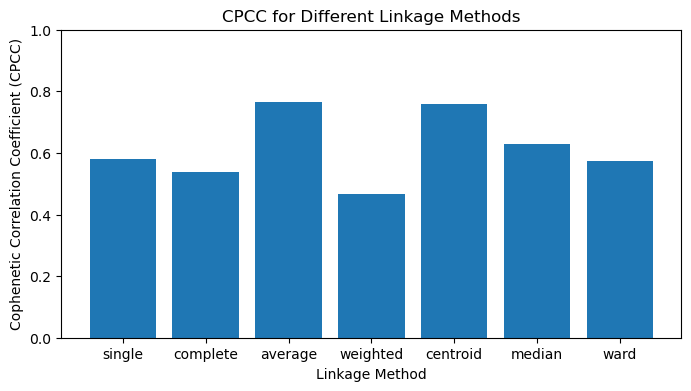

The best linkage method is 'average' with a CPCC of 0.767.


In [21]:
# List of linkage methods to compare, as stated on scipy documentation page
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

# Calculate pairwise distances
cond_dist_mat = pdist(clus_ss)

# Calculate CPCC for each linkage method
cpcc_scores = []
print("The CPCC score for each method:")
for method in linkage_methods:
    # Perform hierarchical clustering
    link_mat = linkage(cond_dist_mat, method=method)
    
    # Calculate CPCC directly
    cpcc, cop_dist_mat = cophenet(link_mat, cond_dist_mat)
    print(f"{method}: {cpcc:.3f}")
    cpcc_scores.append(cpcc)

# Plot CPCC scores for different linkage methods
plt.figure(figsize=(8, 4))
plt.bar(linkage_methods, cpcc_scores)
plt.xlabel('Linkage Method')
plt.ylabel('Cophenetic Correlation Coefficient (CPCC)')
plt.title('CPCC for Different Linkage Methods')
plt.ylim(0, 1)
plt.show()

# Select the best linkage method (highest CPCC)
best_linkage = linkage_methods[np.argmax(cpcc_scores)]
print(f"The best linkage method is '{best_linkage}' with a CPCC of {max(cpcc_scores):.3f}.")

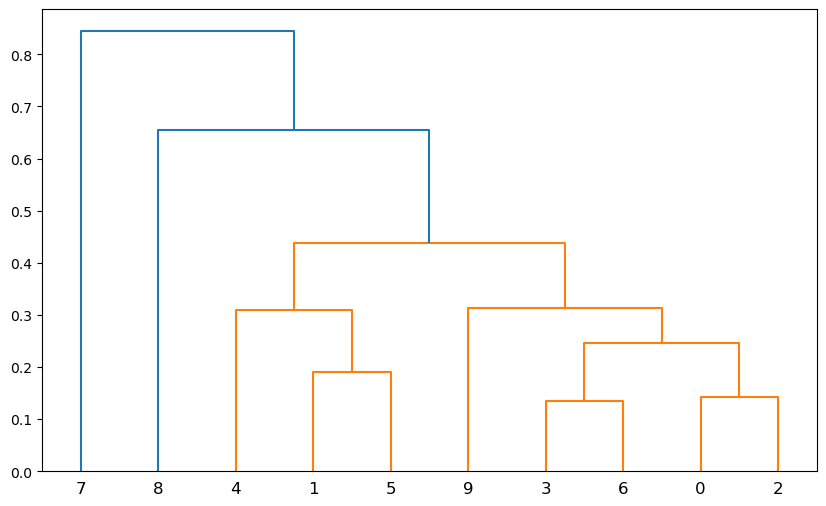

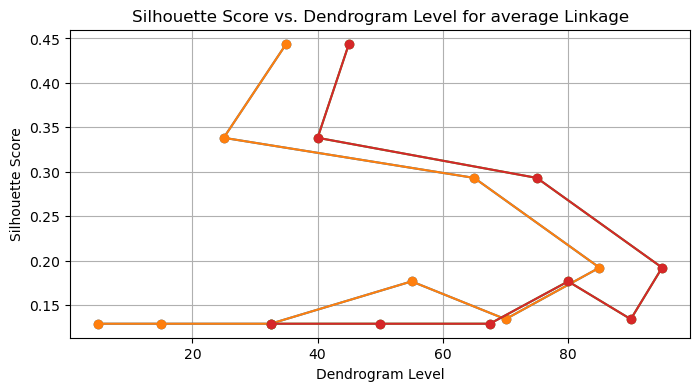

The optimal number of clusters for average linkage is 2


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score

# Generate some sample data (replace this with your own data)
np.random.seed(0)
X = np.random.rand(10, 2)

# Calculate pairwise distances
distances = pdist(X)

# Define the chosen linkage method
chosen_linkage = 'average'

# Perform hierarchical clustering
linkage = hierarchy.linkage(distances, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage)

# Define a range of cluster numbers to consider
cluster_range = range(2, 11)

# Lists to store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    cluster_labels = hierarchy.fcluster(linkage, t=n_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores according to dendrogram level
plt.figure(figsize=(8, 4))
plt.plot(dendrogram['icoord'], silhouette_scores, marker='o', linestyle='-', markersize=6)
plt.xlabel('Dendrogram Level')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Dendrogram Level for {chosen_linkage} Linkage')
plt.grid(True)
plt.show()

# Select the number of clusters that maximizes the silhouette score
optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters for {chosen_linkage} linkage is {optimal_num_clusters}")


In [12]:
# Try the different linkage methods for Euclidean distance.
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward', metric='euclidean')

In [13]:
model = model.fit(clus_ss_df)

In [18]:
link_arr = linkage(clus_ss, method="single", metric="euclidean", optimal_ordering=True)

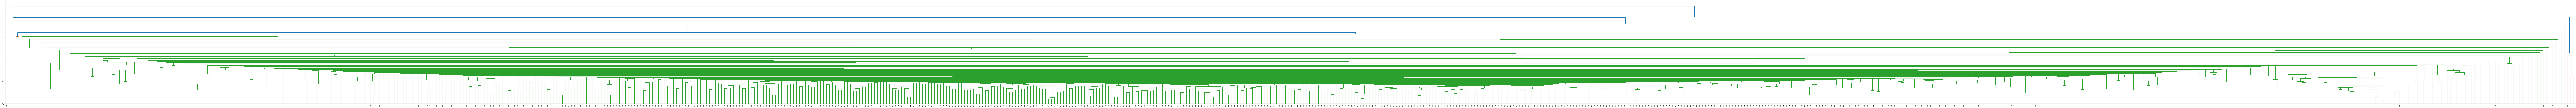

In [20]:
fig = plt.figure(figsize=(250,10))
dn = dendrogram(link_arr)
plt.show()

In [4]:
c, coph_dists = cophenet(link_arr, distances)

NameError: name 'link' is not defined

c, coph_dists = cophenet(link, distances)

In [7]:
clus_df.describe()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,0.736254,1163.453271,0.600595,0.575898,13.759346
std,0.202226,128.004176,0.162513,0.115135,3.737971
min,0.039500,840.000000,0.157600,0.000000,5.000000
25%,0.646900,1075.750000,0.482050,0.516100,11.000000
50%,0.781300,1139.000000,0.600050,0.576650,13.000000
75%,0.881525,1232.000000,0.708600,0.631125,16.000000
max,1.000000,1535.000000,0.975700,1.000000,30.000000


<Axes: xlabel='ADM_RATE'>

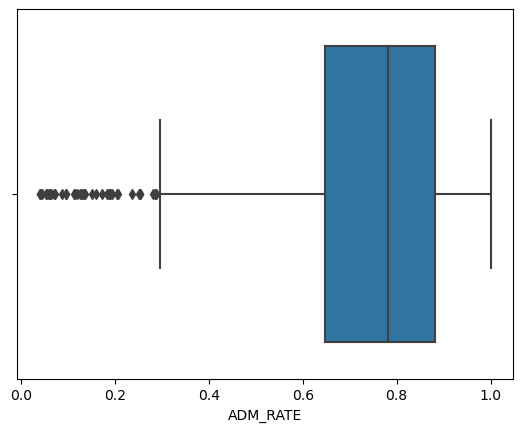

In [9]:
sns.boxplot(x=clus_df["ADM_RATE"])

<Axes: xlabel='SAT_AVG'>

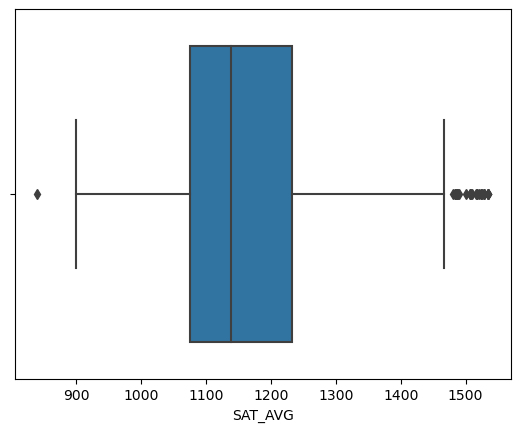

In [10]:
sns.boxplot(x=clus_df["SAT_AVG"])

<Axes: xlabel='C150_4'>

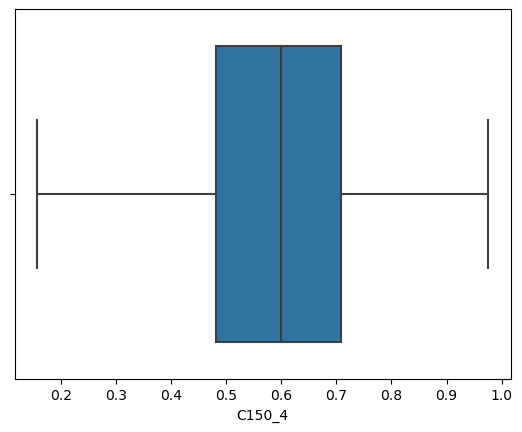

In [11]:
sns.boxplot(x=clus_df["C150_4"])

<Axes: xlabel='SAT_AVG', ylabel='ADM_RATE'>

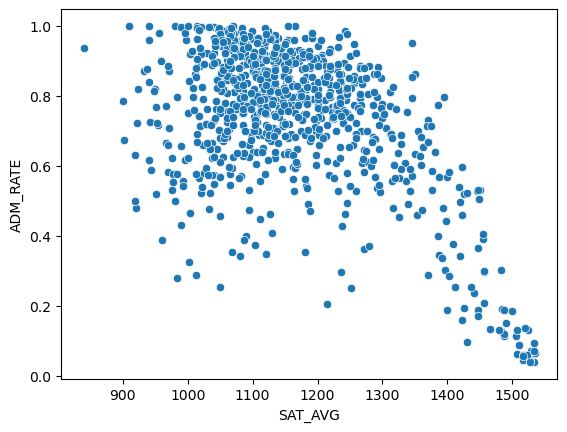

In [6]:
sns.scatterplot(data=clus_df, x="SAT_AVG", y="ADM_RATE")

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.

part 1 take it at face value. fit everything except state.
observe what works and what doesn't work
say what you might do for the issues highlighted
part 2 improve on part 1 and consider the 2 additional variables.
dummy var and one hot encoding for states. one hot encode to remove exact linear dependence
